In [22]:
%load_ext autoreload
%matplotlib inline
%load_ext nb_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [23]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from helpers import plot_class
from helpers import helpfunction as helper

pd.set_option("display.max_columns", 500)

<IPython.core.display.Javascript object>

In [24]:
%autoreload

[autoreload of helpers.plot_class failed: Traceback (most recent call last):
  File "/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 280, in update_instances
    frame = next(frame_nfo.frame for frame_nfo in inspect.stack()
StopIteration
]


<IPython.core.display.Javascript object>

In [25]:
run = 3
input_dir = "./input/05Dec/"
output_dir = "./output/run{}/".format(run)

<IPython.core.display.Javascript object>

In [26]:
data = pickle.load(open(input_dir + "run{}_slimmed.pckl".format(run), "rb"))
samples = list(data.keys())
title_str = "MicroBooNE Run{}: {:.1e} POT".format(run, data["on"]["pot"])

<IPython.core.display.Javascript object>

In [27]:
q_muon_select = "(trk_llr_pid_score_v>0.2 & trk_score_v>0.8 & trk_len_v>10 & pfp_generation_v==2 & trk_distance_v<4)"
q_event_select = "(reco_fid_vol & muon_candidate  & CosmicIP>20 & slpdg==14 & topological_score>0.1 & all_start_contained)"
q_preselect_tracks = "(reco_fid_vol & trk_score_v>0.8 & trk_len_v>20 & pfp_generation_v==2 & trk_distance_v<4 & CosmicIP>20 & slpdg==14 & all_start_contained)"
q_crt = "(~(crtveto & crthitpe>100) & _closestNuCosmicDist>20 & all_end_contained)"
# q_event_select += " & " + q_crt

<IPython.core.display.Javascript object>

In [28]:
fields = list(data["nu"]["daughters"].keys())
[f for f in fields if "2" in f]

['SliceCaloEnergy2', 'NeutrinoEnergy2']

<IPython.core.display.Javascript object>

In [29]:
for k, v in data.items():
    # Fill in default for missing field if no CRT data
    if "_closestNuCosmicDist" not in v["daughters"]:
        v["daughters"]["_closestNuCosmicDist"] = 999

    # Number of tracks at vertex
    v["daughters"]["track_at_vtx"] = v["daughters"].eval(
        "trk_distance_v<3 & trk_distance_v>=0 & trk_score_v>0.3"
    )
    v["daughters"]["track_at_vtx"] = (
        v["daughters"]["track_at_vtx"].groupby("event").transform(sum)
    )

    # Add fiducial and containnment fields
    v["daughters"]["reco_fid_vol"] = np.repeat(
        helper.is_fid(
            *v["daughters"][
                ["reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z"]
            ]
            .xs(0, level="daughter")
            .values.T
        ),
        v["daughters"]["n_pfps"].xs(0, level="daughter"),
    )

    muon_candidate = v["daughters"].eval(q_muon_select)
    muon_cand_maxll = (
        v["daughters"][muon_candidate]["trk_llr_pid_score_v"]
        .groupby("event")
        .transform(max)
        == v["daughters"][muon_candidate]["trk_llr_pid_score_v"]
    )
    v["daughters"]["muon_candidate"] = False
    v["daughters"].loc[
        muon_cand_maxll[muon_cand_maxll == True].index, "muon_candidate"
    ] = True

    end_mask = helper.is_contain(
        v["daughters"]["trk_sce_end_x_v"],
        v["daughters"]["trk_sce_end_y_v"],
        v["daughters"]["trk_sce_end_z_v"],
    )
    start_mask = helper.is_contain(
        v["daughters"]["trk_sce_start_x_v"],
        v["daughters"]["trk_sce_start_y_v"],
        v["daughters"]["trk_sce_start_z_v"],
    )
    v["daughters"]["all_start_contained"] = start_mask
    v["daughters"]["all_start_contained"] = (
        v["daughters"]["all_start_contained"].groupby("event").transform(min)
    )
    v["daughters"]["all_end_contained"] = end_mask
    v["daughters"]["all_end_contained"] = (
        v["daughters"]["all_end_contained"].groupby("event").transform(min)
    )
    # This code defines a containment of all other objects except of the muon.
    v["daughters"]["non_muon_end_contained"] = end_mask
    v["daughters"].loc[
        muon_cand_maxll[muon_cand_maxll == True].index, "non_muon_end_contained"
    ] = True
    v["daughters"]["non_muon_end_contained"] = (
        v["daughters"]["non_muon_end_contained"].groupby("event").transform(min)
    )

    # Muon selection
    v["daughters"]["numuccinc"] = v["daughters"].eval(q_event_select)
    v["daughters"]["numuccinc_crt"] = (
        v["daughters"].eval(q_crt) * v["daughters"]["numuccinc"]
    )

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


<IPython.core.display.Javascript object>

In [30]:
data["nu"]["mc"].keys()

dict_keys(['mc_pdg', 'mc_E', 'ccnc', 'theta', 'true_nu_vtx_x', 'true_nu_vtx_y', 'true_nu_vtx_z', 'n_pfps', 'interaction', 'weightSpline', 'leeweight', 'category', 'nu_e', 'nu_pdg', 'nelec', 'npion', 'npi0', 'nproton', 'nmuon', 'nu_completeness_from_pfp', 'nu_purity_from_pfp', 'nueccinc', 'true_category'])

<IPython.core.display.Javascript object>

In [31]:
nu_keys_true = [
    "nu_pdg",
    "nu_e",
    "true_nu_vtx_x",
    "true_nu_vtx_y",
    "true_nu_vtx_z",
    "nmuon",
    "nproton",
    "npi0",
    "npion",
    "interaction",
    "weightSpline",
]
nu_df = pd.DataFrame({k: data["nu"]["mc"][k] for k in nu_keys_true})

<IPython.core.display.Javascript object>

In [32]:
nu_df.head()

,nu_pdg,nu_e,true_nu_vtx_x,true_nu_vtx_y,true_nu_vtx_z,nmuon,nproton,npi0,npion,interaction,weightSpline
0,14,1.564474,-10.196728,-22.561237,612.527588,1,2,1,0,2,1.0
1,14,1.548862,66.593971,-114.305840,561.372864,1,1,1,1,2,1.0
2,14,1.151643,267.631805,68.061867,402.268311,1,2,0,0,1,1.0
3,14,1.221684,91.436424,-76.463081,964.465393,0,0,0,0,0,1.0
4,-14,1.423034,65.620003,60.304016,135.967438,0,0,0,1,1,1.0


<IPython.core.display.Javascript object>

In [33]:
nu_df["true_vtx_fid"] = helper.is_fid(
    data["nu"]["mc"]["true_nu_vtx_x"],
    data["nu"]["mc"]["true_nu_vtx_y"],
    data["nu"]["mc"]["true_nu_vtx_z"],
)

<IPython.core.display.Javascript object>

In [34]:
q_30 = "abs(nu_pdg)==14 & nmuon==1 & nproton==0 & (npi0+npion)==0 & true_vtx_fid"
q_31 = "abs(nu_pdg)==14 & nmuon==1 & nproton>0 & (npi0+npion)==0 & true_vtx_fid"
q_32 = "abs(nu_pdg)==14 & nmuon==1 & (npi0+npion)>0 & true_vtx_fid"
q_33 = "abs(nu_pdg)==14 & nmuon==0 & true_vtx_fid"
q_10 = "abs(nu_pdg)==12 & true_vtx_fid"
q_5 = "true_vtx_fid==0"
new_cat = (
    nu_df.eval(q_30) * 30
    + nu_df.eval(q_31) * 31
    + nu_df.eval(q_32) * 32
    + nu_df.eval(q_33) * 33
    + nu_df.eval(q_10) * 10
    + nu_df.eval(q_5) * 5
)
nu_df["category"] = new_cat

<IPython.core.display.Javascript object>

In [35]:
# Do not use the fid vol of the analyser at all
q_30 = "true_fid_vol & abs(nu_pdg)==14 & nmuon==1 & nproton==0 & (npi0+npion)==0"
q_31 = "true_fid_vol & abs(nu_pdg)==14 & nmuon==1 & nproton>0 & (npi0+npion)==0"
q_32 = "true_fid_vol & abs(nu_pdg)==14 & nmuon==1 & (npi0+npion)>0"
q_33 = "true_fid_vol & abs(nu_pdg)==14 & nmuon==0"
q_10 = "true_fid_vol & abs(nu_pdg)==12"
q_5 = "true_fid_vol==0"

for k, v in data.items():
    if k not in helper.data_samples:

        v["daughters"]["true_fid_vol"] = np.repeat(
            helper.is_fid(
                *v["daughters"][["true_nu_vtx_x", "true_nu_vtx_y", "true_nu_vtx_z"]]
                .xs(0, level="daughter")
                .values.T
            ),
            v["daughters"]["n_pfps"].xs(0, level="daughter"),
        )

        new_cat = (
            v["daughters"].eval(q_30) * 30
            + v["daughters"].eval(q_31) * 31
            + v["daughters"].eval(q_32) * 32
            + v["daughters"].eval(q_33) * 33
            + v["daughters"].eval(q_10) * 10
            + v["daughters"].eval(q_5) * 5
        )
        v["daughters"]["category"] = new_cat
        cosmic = (v["daughters"]["nu_purity_from_pfp"] < 0.5) & (
            v["daughters"]["category"] != 5
        )
        v["daughters"].loc[cosmic, "category"] = 4

<IPython.core.display.Javascript object>

In [36]:
q_30 = "true_fid_vol & abs(nu_pdg)==14 & nmuon==1 & (interaction==0 | interaction==5)"
q_31 = "true_fid_vol & abs(nu_pdg)==14 & nmuon==1 & (interaction==1 | interaction==3)"
q_32 = "true_fid_vol & abs(nu_pdg)==14 & nmuon==1 & interaction==2"
q_310 = "true_fid_vol & abs(nu_pdg)==14 & nmuon==1 & interaction==10"
q_33 = "true_fid_vol & abs(nu_pdg)==14 & nmuon==0"
q_10 = "true_fid_vol & abs(nu_pdg)==12"
q_5 = "true_fid_vol==0"

for k, v in data.items():
    if k not in helper.data_samples:
        new_cat = (
            v["daughters"].eval(q_30) * 30
            + v["daughters"].eval(q_31) * 31
            + v["daughters"].eval(q_32) * 32
            + v["daughters"].eval(q_310) * 310
            + v["daughters"].eval(q_33) * 33
            + v["daughters"].eval(q_10) * 10
            + v["daughters"].eval(q_5) * 5
        )
        v["daughters"]["cat_int"] = new_cat
        cosmic = (v["daughters"]["nu_purity_from_pfp"] < 0.5) & (
            v["daughters"]["cat_int"] != 5
        )
        v["daughters"].loc[cosmic, "cat_int"] = 4

        # Add the modified purity/completeness to account for overlay.
        overlay_mask = v["daughters"].eval(
            "backtracked_overlay_purity>backtracked_purity"
        )
        v["daughters"].loc[overlay_mask, "backtracked_pdg"] = 0
        v["daughters"].loc[overlay_mask, "backtracked_purity"] = v["daughters"].loc[
            overlay_mask, "backtracked_overlay_purity"
        ]
        v["daughters"].loc[overlay_mask, "backtracked_completeness"] = 0

<IPython.core.display.Javascript object>

In [37]:
print(data["nu"]["daughters"].query("numuccinc")["category"].value_counts())
print(data["nu"]["daughters"].query("numuccinc")["cat_int"].value_counts())
print(nu_df["interaction"].value_counts())
print(sum(data["on"]["daughters"].eval("numuccinc")))

31    91114
32    41250
30    17527
5     13488
33     6825
4      5840
10      179
0         1
Name: category, dtype: int64
30     74235
31     47819
310    18868
5      13488
32      8969
33      6825
4       5840
10       179
0          1
Name: cat_int, dtype: int64
0     511465
1     357703
10    109980
2      88573
3       2597
5         70
Name: interaction, dtype: int64
1270


<IPython.core.display.Javascript object>

In [38]:
sum(data["nu"]["daughters"].eval("numuccinc & category>29 & category<33")) / sum(
    nu_df.eval("category>29 & category<33")
)

0.5233916699256942

<IPython.core.display.Javascript object>

## Plots

In [39]:
# Load the plotting module
plotter = plot_class.Plotter(data, signal="numu", genie_version="mcc9")

Initialisation completed!


<IPython.core.display.Javascript object>

/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:400: RuntimeWarning: invalid value encountered in true_divide
  eff = num_w_h / den_w_h


37505.701109707355
18102.12444716692
168879.09091866016
92087.93471306562
84727.47990369797
41224.78230392933


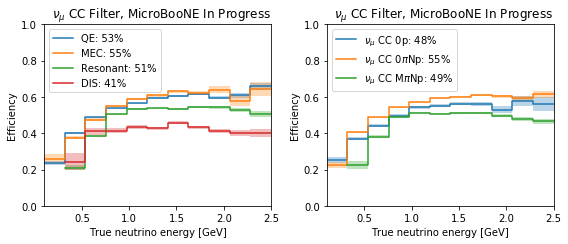

<IPython.core.display.Javascript object>

In [40]:
# eff per mode
cats = [0, 1, 2, 10]
field = "nu_e"
x_min = 0.1
x_max = 2.5
n_bins = 12
fig, ax = plt.subplots(ncols=2, figsize=(8, 3.5))


cats = [0, 10, 1, 2]
for cat in cats:
    num = (
        data["nu"]["daughters"]
        .query("numuccinc & category>29 & category<33")
        .query("interaction==@cat")[field]
    )
    den = nu_df.query("category>29 & category<33").query("interaction==@cat")[field]

    num_w = (
        data["nu"]["daughters"]
        .query("numuccinc & category>29 & category<33")
        .query("interaction==@cat")["weightSpline"]
    )
    den_w = nu_df.query("category>29 & category<33").query("interaction==@cat")[
        "weightSpline"
    ]

    eff, unc_low, unc_up, edges = plot_class.efficiency_post(
        num, den, num_w=num_w, den_w=den_w, n_bins=n_bins, x_min=x_min, x_max=x_max
    )
    ax[0].fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
    ax[0].step(
        edges,
        eff,
        where="post",
        label="{0}: {1:.0f}%".format(
            plotter.dicts.int_labels_true[cat], sum(num_w) / sum(den_w) * 100
        ),
    )
ax[0].set_title(r"$\nu_\mu$ CC Filter, MicroBooNE In Progress", loc="right")
ax[0].set_xlabel("True neutrino energy [GeV]")
ax[0].set_ylabel("Efficiency")
ax[0].set_ylim(0, 1)
ax[0].set_xlim(x_min, x_max)
ax[0].legend(loc="upper left")


cats = [30, 31, 32]
for cat in cats:
    num = (
        data["nu"]["daughters"]
        .query("numuccinc & category>29 & category<33")
        .query("category==@cat")[field]
    )
    den = nu_df.query("category>29 & category<33").query("category==@cat")[field]

    num_w = (
        data["nu"]["daughters"]
        .query("numuccinc & category>29 & category<33")
        .query("category==@cat")["weightSpline"]
    )
    den_w = nu_df.query("category>29 & category<33").query("category==@cat")[
        "weightSpline"
    ]
    print(sum(den_w))
    print(sum(num_w))
    eff, unc_low, unc_up, edges = plot_class.efficiency_post(
        num, den, num_w=num_w, den_w=den_w, n_bins=n_bins, x_min=x_min, x_max=x_max
    )
    ax[1].fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
    ax[1].step(
        edges,
        eff,
        where="post",
        label="{0}: {1:.0f}%".format(
            plotter.dicts.category_labels[cat], sum(num_w) / sum(den_w) * 100
        ),
    )
ax[1].set_title(r"$\nu_\mu$ CC Filter, MicroBooNE In Progress", loc="right")
ax[1].set_xlabel("True neutrino energy [GeV]")
ax[1].set_ylabel("Efficiency")
ax[1].set_ylim(0, 1)
ax[1].set_xlim(x_min, x_max)
ax[1].legend(loc="upper left")

fig.tight_layout()
fig.savefig(output_dir + "numu_efficiency_run{}.pdf".format(run), bbox_inches="tight")

MC category: QE: 361. 	#entries 74235
MC category: Resonant: 228. 	#entries 47819
MC category: DIS: 43. 	#entries 8969
MC category: MEC: 90. 	#entries 18868
MC category: $\nu_\mu$ NC: 32. 	#entries 6825
MC category: $\nu_e$: 0.87 	#entries 5383
MC category: Cosmic: 28. 	#entries 6681
MC category: Out of FV: 65. 	#entries 13738
MC category: Out of Cryo: 40. 	#entries 1999
MC category: No slice: 0.0048 	#entries 1


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:497: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:498: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


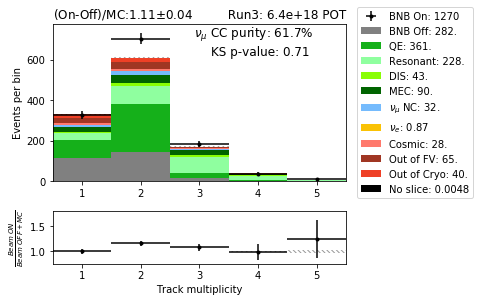

<IPython.core.display.Javascript object>

In [41]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(4.2 * plotter.gr, 4.3),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax,
    "track_at_vtx",
    "Track multiplicity",
    N_bins=5,
    x_min=0.5,
    x_max=5.5,
    query="numuccinc",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="int",
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.9,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(
    output_dir + "data_mc/numu_vtxntrack_int_run{}.pdf".format(run), bbox_inches="tight"
)

MC category: $\nu_\mu$ CC 0p: 86. 	#entries 17527
MC category: $\nu_\mu$ CC 0$\pi$Np: 438. 	#entries 91114
MC category: $\nu_\mu$ CC M$\pi$Np: 196. 	#entries 41250
MC category: $\nu_\mu$ NC: 32. 	#entries 6825
MC category: $\nu_e$: 0.87 	#entries 5383
MC category: Cosmic: 28. 	#entries 6681
MC category: Out of FV: 65. 	#entries 13738
MC category: Out of Cryo: 40. 	#entries 1999
MC category: No slice: 0.0048 	#entries 1


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:497: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:498: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


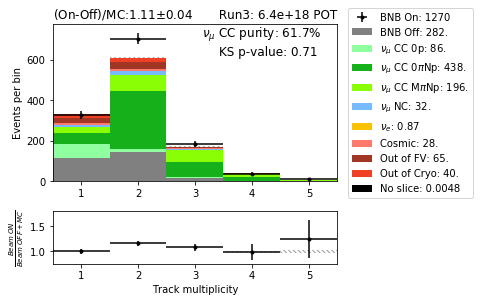

<IPython.core.display.Javascript object>

In [42]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(4.2 * plotter.gr, 4.3),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax,
    "track_at_vtx",
    "Track multiplicity",
    N_bins=5,
    x_min=0.5,
    x_max=5.5,
    query="numuccinc",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="cat",
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.95,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(
    output_dir + "data_mc/numu_vtxntrack_cat_run{}.pdf".format(run), bbox_inches="tight"
)

MC category: QE: 361. 	#entries 74235
MC category: Resonant: 228. 	#entries 47819
MC category: DIS: 43. 	#entries 8969
MC category: MEC: 90. 	#entries 18868
MC category: $\nu_\mu$ NC: 32. 	#entries 6825
MC category: $\nu_e$: 0.87 	#entries 5383
MC category: Cosmic: 28. 	#entries 6681
MC category: Out of FV: 65. 	#entries 13738
MC category: Out of Cryo: 40. 	#entries 1999
MC category: No slice: 0.0048 	#entries 1


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:497: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:498: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


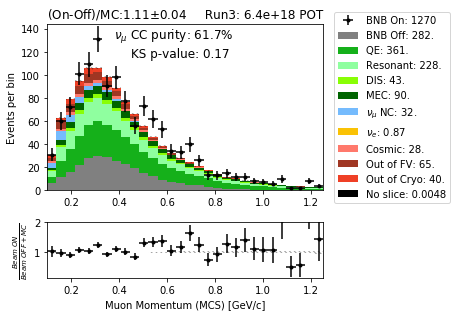

<IPython.core.display.Javascript object>

In [43]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(4 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax,
    "trk_mcs_muon_mom_v",
    "Muon Momentum (MCS) [GeV/c]",
    N_bins=30,
    x_min=0.1,
    x_max=1.25,
    query="numuccinc",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="int",
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.7,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(
    output_dir + "data_mc/numu_mcsmom_run{}.pdf".format(run), bbox_inches="tight"
)

MC category: QE: 361. 	#entries 74235
MC category: Resonant: 228. 	#entries 47819
MC category: DIS: 43. 	#entries 8969
MC category: MEC: 90. 	#entries 18868
MC category: $\nu_\mu$ NC: 32. 	#entries 6825
MC category: $\nu_e$: 0.87 	#entries 5383
MC category: Cosmic: 28. 	#entries 6681
MC category: Out of FV: 65. 	#entries 13738
MC category: Out of Cryo: 40. 	#entries 1999
MC category: No slice: 0.0048 	#entries 1


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:497: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:498: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


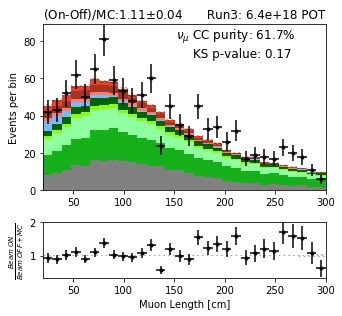

<IPython.core.display.Javascript object>

In [44]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(3 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax,
    "trk_len_v",
    "Muon Length [cm]",
    N_bins=30,
    x_min=20,
    x_max=300,
    query="numuccinc",
    legend=False,
    title_str=title_str.split("NE")[-1],
    kind="int",
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.9,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(
    output_dir + "data_mc/numu_trklen_run{}.pdf".format(run), bbox_inches="tight"
)

MC category: QE: 361. 	#entries 74235
MC category: Resonant: 228. 	#entries 47819
MC category: DIS: 43. 	#entries 8969
MC category: MEC: 90. 	#entries 18868
MC category: $\nu_\mu$ NC: 32. 	#entries 6825
MC category: $\nu_e$: 0.87 	#entries 5383
MC category: Cosmic: 28. 	#entries 6681
MC category: Out of FV: 65. 	#entries 13738
MC category: Out of Cryo: 40. 	#entries 1999
MC category: No slice: 0.0048 	#entries 1


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:497: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:498: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


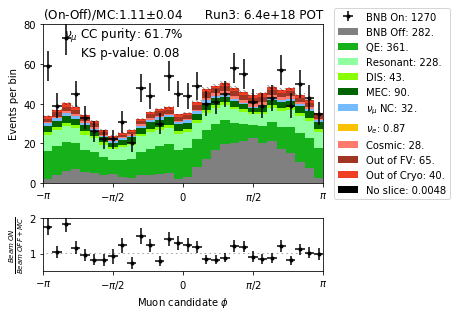

<IPython.core.display.Javascript object>

In [45]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(4 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax,
    "trk_phi_v",
    r"Muon candidate $\phi$",
    N_bins=30,
    x_min=-np.pi,
    x_max=np.pi,
    query="numuccinc",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="int",
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.0,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

x_ticks = [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi]
x_labels = [r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"]
ax[1].set_xticks(x_ticks)
ax[1].set_xticklabels(x_labels)
ax[0].set_xticks(x_ticks)
ax[0].set_xticklabels(x_labels)


fig.tight_layout()
fig.savefig(output_dir + "data_mc/numu_phi_run{}.pdf".format(run), bbox_inches="tight")

MC category: QE: 361. 	#entries 74235
MC category: Resonant: 228. 	#entries 47819
MC category: DIS: 43. 	#entries 8969
MC category: MEC: 90. 	#entries 18868
MC category: $\nu_\mu$ NC: 32. 	#entries 6825
MC category: $\nu_e$: 0.87 	#entries 5383
MC category: Cosmic: 28. 	#entries 6681
MC category: Out of FV: 65. 	#entries 13738
MC category: Out of Cryo: 40. 	#entries 1999
MC category: No slice: 0.0048 	#entries 1


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:497: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:498: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


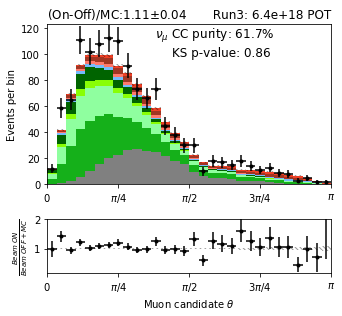

<IPython.core.display.Javascript object>

In [46]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(3 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax,
    "trk_theta_v",
    r"Muon candidate $\theta$",
    N_bins=30,
    x_min=0,
    x_max=np.pi,
    query="numuccinc",
    legend=False,
    title_str=title_str.split("NE")[-1],
    kind="int",
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.8,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

x_ticks = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi]
x_labels = [r"$0$", r"$\pi/4$", r"$\pi/2$", r"$3\pi/4$", r"$\pi$"]
ax[1].set_xticks(x_ticks)
ax[1].set_xticklabels(x_labels)
ax[0].set_xticks(x_ticks)
ax[0].set_xticklabels(x_labels)


fig.tight_layout()
fig.savefig(
    output_dir + "data_mc/numu_theta_run{}.pdf".format(run), bbox_inches="tight"
)

MC category: $\nu_\mu$ CC 0p: 109. 	#entries 21958
MC category: $\nu_\mu$ CC 0$\pi$Np: 662. 	#entries 137680
MC category: $\nu_\mu$ CC M$\pi$Np: 316. 	#entries 66524
MC category: $\nu_\mu$ NC: 83. 	#entries 17527
MC category: $\nu_e$: 1.7 	#entries 9912
MC category: Cosmic: 73. 	#entries 17418
MC category: Out of FV: 167. 	#entries 35351
MC category: Out of Cryo: 92. 	#entries 4641
MC category: No slice: 0.0048 	#entries 1


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:497: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:498: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


MC category: $p$: 295. 	#entries 66205
MC category: $\mu$: 852. 	#entries 170887
MC category: $e$: 0.26 	#entries 2109
MC category: $\pi^{\pm}$: 96. 	#entries 22540
MC category: $\gamma$: 1.8 	#entries 413
MC category: $K$: 0.51 	#entries 136
MC category: Cosmic: 257. 	#entries 48722


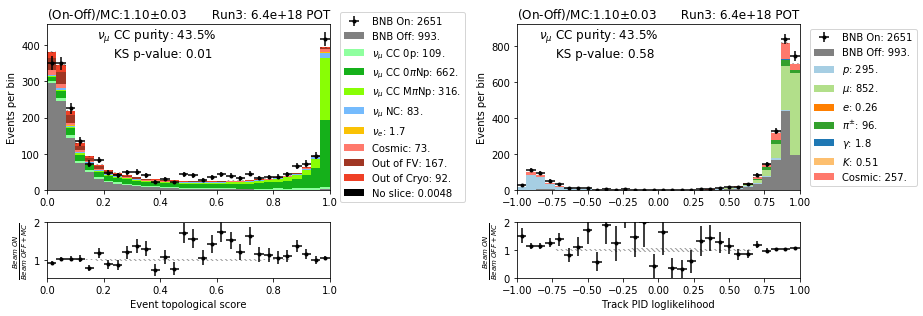

<IPython.core.display.Javascript object>

In [47]:
fig, ax = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(8 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[0],
    "topological_score",
    r"Event topological score",
    N_bins=30,
    x_min=0,
    x_max=1,
    query=q_preselect_tracks,
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="cat",
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.6,
    ax[0][0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)
ax[0][0]

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[1],
    "trk_llr_pid_score_v",
    r"Track PID loglikelihood",
    N_bins=30,
    x_min=-1,
    x_max=1,
    query=q_preselect_tracks,
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="pdg",
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.0,
    ax[0][1].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)


fig.tight_layout()
fig.savefig(output_dir + "data_mc/numu_pret_run{}.pdf".format(run), bbox_inches="tight")

MC category: QE: 361. 	#entries 74235
MC category: Resonant: 228. 	#entries 47819
MC category: DIS: 43. 	#entries 8969
MC category: MEC: 90. 	#entries 18868
MC category: $\nu_\mu$ NC: 32. 	#entries 6825
MC category: $\nu_e$: 0.87 	#entries 5383
MC category: Cosmic: 28. 	#entries 6681
MC category: Out of FV: 65. 	#entries 13738
MC category: Out of Cryo: 40. 	#entries 1999
MC category: No slice: 0.0048 	#entries 1


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:497: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:498: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


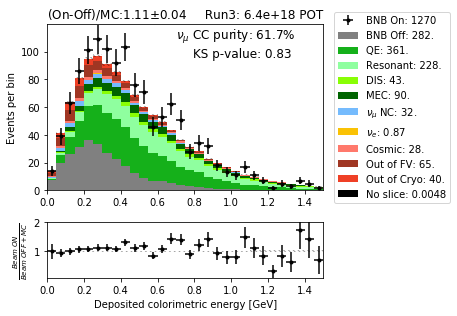

<IPython.core.display.Javascript object>

In [48]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(4 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax,
    "NeutrinoEnergy2/1000",
    "Deposited colorimetric energy [GeV]",
    N_bins=30,
    x_min=0,
    x_max=1.5,
    query="numuccinc",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="int",
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.9,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(
    output_dir + "data_mc/numu_caloe_run{}.pdf".format(run), bbox_inches="tight"
)

MC category: $\nu_\mu$ CC 0p: 86. 	#entries 17527
MC category: $\nu_\mu$ CC 0$\pi$Np: 438. 	#entries 91114
MC category: $\nu_\mu$ CC M$\pi$Np: 196. 	#entries 41250
MC category: $\nu_\mu$ NC: 32. 	#entries 6825
MC category: $\nu_e$: 0.87 	#entries 5383
MC category: Cosmic: 28. 	#entries 6681
MC category: Out of FV: 65. 	#entries 13738
MC category: Out of Cryo: 40. 	#entries 1999


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:497: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side="right")]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:498: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side="right")]]


MC category: No slice: 0.0048 	#entries 1
MC category: $\nu_\mu$ CC 0p: 86. 	#entries 17527
MC category: $\nu_\mu$ CC 0$\pi$Np: 438. 	#entries 91114
MC category: $\nu_\mu$ CC M$\pi$Np: 196. 	#entries 41250
MC category: $\nu_\mu$ NC: 32. 	#entries 6825
MC category: $\nu_e$: 0.87 	#entries 5383
MC category: Cosmic: 28. 	#entries 6681
MC category: Out of FV: 65. 	#entries 13738
MC category: Out of Cryo: 40. 	#entries 1999
MC category: No slice: 0.0048 	#entries 1
MC category: $\nu_\mu$ CC 0p: 86. 	#entries 17527
MC category: $\nu_\mu$ CC 0$\pi$Np: 438. 	#entries 91114
MC category: $\nu_\mu$ CC M$\pi$Np: 196. 	#entries 41250
MC category: $\nu_\mu$ NC: 32. 	#entries 6825
MC category: $\nu_e$: 0.87 	#entries 5383
MC category: Cosmic: 28. 	#entries 6681
MC category: Out of FV: 65. 	#entries 13738
MC category: Out of Cryo: 40. 	#entries 1999
MC category: No slice: 0.0048 	#entries 1


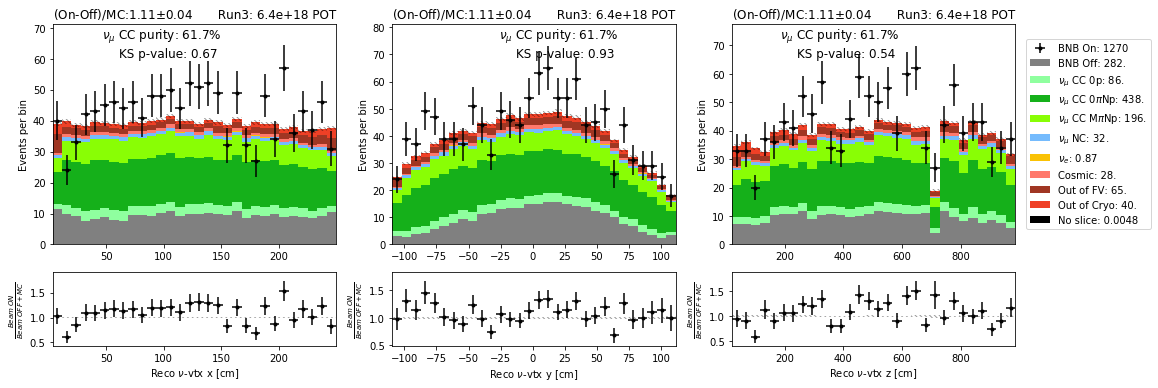

<IPython.core.display.Javascript object>

In [49]:
field = ["reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z"]
label = [r"Reco $\nu$-vtx x [cm]", r"Reco $\nu$-vtx y [cm]", r"Reco $\nu$-vtx z [cm]"]
legend = [False, False, True]

fig, ax = plt.subplots(
    ncols=3,
    nrows=2,
    figsize=(10 * plotter.gr, 5.5),
    gridspec_kw={"height_ratios": [3, 1]},
)

for i in range(3):
    ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
        ax.T[i],
        field[i],
        label[i],
        N_bins=30,
        x_min=helper.fid_box[i][0],
        x_max=helper.fid_box[i][1],
        query="numuccinc",
        legend=legend[i],
        title_str=title_str.split("NE")[-1],
        kind="cat",
        y_max_scaler=1.25,
    )

    ax[0][i].text(
        ax[0][i].get_xlim()[1] * 0.6,
        ax[0][i].get_ylim()[1] * 0.85,
        r"$\nu_\mu$"
        + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
        horizontalalignment="right",
        fontsize=12,
    )


fig.tight_layout()
fig.savefig(
    output_dir + "data_mc/numu_recovtx_run{}.pdf".format(run), bbox_inches="tight"
)

In [50]:
# Fidvol ratio:
fidvol_vtx_old = [10, 10, 10, 10, 10, 50]
fidvol_vtx_new = [5, 5, 6, 6, 20, 50]

fv_old = 1
fv_new = 1

for i in range(3):
    fv_old *= (helper.upper[i] - fidvol_vtx_old[2 * i]) - (
        helper.lower[i] + fidvol_vtx_old[2 * i + 1]
    )
    fv_new *= (helper.upper[i] - fidvol_vtx_new[2 * i]) - (
        helper.lower[i] + fidvol_vtx_new[2 * i + 1]
    )

# Marco
fv_marco = (233 - 70) * (256.35 - 24) * (1036.8 - 25 - 100 - 85)

print(fv_new / fv_marco)
print(fv_new / fv_old)

1.6809342754712184
1.0703864950625397


<IPython.core.display.Javascript object>

# Done

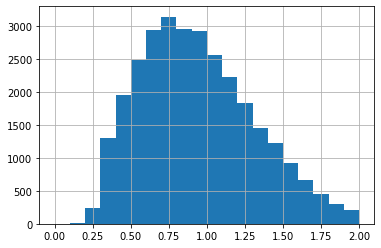

<IPython.core.display.Javascript object>

In [51]:
# Giusseppes request for true energy of calo energy
data["nu"]["daughters"].query("numuccinc & NeutrinoEnergy2<250")["nu_e"].hist(
    bins=20, range=(0, 2)
)

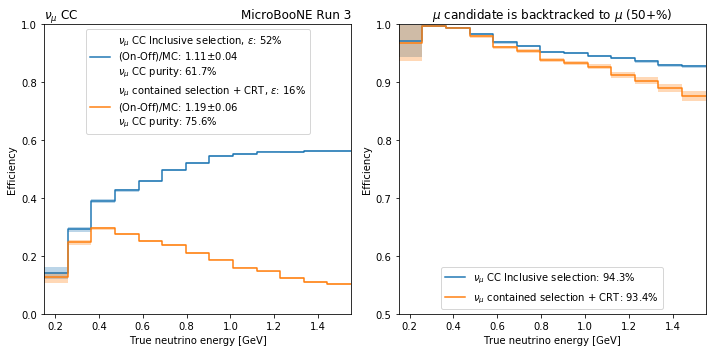

<IPython.core.display.Javascript object>

In [52]:
# eff per mode
field = "nu_e"
x_min = 0.15
x_max = 1.55
n_bins = 14
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
labs = [r"$\nu_\mu$ CC Inclusive selection", r"$\nu_\mu$ contained selection + CRT"]


for q_s, lab in zip(["numuccinc", "numuccinc_crt"], labs):
    # get purity and ratio
    ratio, purity = plotter.get_ratio_and_purity(q_s)

    num = data["nu"]["daughters"].query("category>29 & category<33").query(q_s)[field]
    den = nu_df.query("category>29 & category<33")[field]

    num_w = (
        data["nu"]["daughters"]
        .query("category>29 & category<33")
        .query(q_s)["weightSpline"]
    )
    den_w = nu_df.query("category>29 & category<33")["weightSpline"]

    eff, unc_low, unc_up, edges = plot_class.efficiency_post(
        num, den, num_w=num_w, den_w=den_w, n_bins=n_bins, x_min=x_min, x_max=x_max
    )
    ax[0].fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
    ax[0].step(
        edges,
        eff,
        where="post",
        label=r"{}, $\varepsilon$: {:.0%}".format(lab, sum(num_w) / sum(den_w))
        + "\n"
        + r"(On-Off)/MC: {:.2f}$\pm${:.2f}".format(ratio[0], ratio[2])
        + "\n"
        + r"$\nu_\mu$ CC purity: {:.1%}".format(purity),
    )
    ax[0].set_title(r"$\nu_\mu$ CC", loc="left")
    ax[0].set_title("MicroBooNE Run 3", loc="right")
    ax[0].set_xlabel("True neutrino energy [GeV]")
    ax[0].set_ylabel("Efficiency")
    ax[0].set_ylim(0, 1)
    ax[0].set_xlim(x_min, x_max)
    ax[0].legend(loc="upper center")

    num = (
        data["nu"]["daughters"]
        .query("category>29 & category<33")
        .query(q_s)
        .query("abs(backtracked_pdg)==13")[field]
    )
    den = data["nu"]["daughters"].query("category>29 & category<33").query(q_s)[field]

    num_w = (
        data["nu"]["daughters"]
        .query("category>29 & category<33")
        .query(q_s)
        .query("abs(backtracked_pdg)==13")["weightSpline"]
    )
    den_w = (
        data["nu"]["daughters"]
        .query("category>29 & category<33")
        .query(q_s)["weightSpline"]
    )

    eff, unc_low, unc_up, edges = plot_class.efficiency_post(
        num, den, num_w=num_w, den_w=den_w, n_bins=n_bins, x_min=x_min, x_max=x_max
    )
    ax[1].fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
    ax[1].step(
        edges,
        eff,
        where="post",
        label="{}: {:.1%}".format(lab, sum(num_w) / sum(den_w)),
    )
    ax[1].set_title(r"$\mu$ candidate is backtracked to $\mu$ (50+%)")
    ax[1].set_xlabel("True neutrino energy [GeV]")
    ax[1].set_ylabel("Efficiency")
    ax[1].set_ylim(0.5, 1)
    ax[1].set_xlim(x_min, x_max)
    ax[1].legend(loc="lower center")

fig.tight_layout()
fig.savefig(output_dir + "numu_muon_purity_run{}.pdf".format(run), bbox_inches="tight")

In [53]:
print(
    data["nu"]["daughters"]
    .query("category>29 & category<33")
    .query("numuccinc_crt")["backtracked_pdg"]
    .abs()
    .value_counts()
)
print(
    data["nu"]["daughters"]
    .query("category>29 & category<33")
    .query("numuccinc")["backtracked_pdg"]
    .abs()
    .value_counts()
)

13      42606
211      2159
2212      544
0         401
22         25
321         4
Name: backtracked_pdg, dtype: int64
13      141204
211       5366
2212      1973
0         1291
22          47
321          8
11           2
Name: backtracked_pdg, dtype: int64


<IPython.core.display.Javascript object>

In [54]:
data["nu"]["daughters"]["mu_cand"] = data["nu"]["daughters"].eval(q_muon_select)
sums = (
    data["nu"]["daughters"]
    .query("category>29 & category<33")["mu_cand"]
    .groupby("event")
    .transform(sum)
)
print(sums.value_counts() / len(sums) * 100)

1.0    68.741116
2.0    16.537485
0.0    13.025464
3.0     1.535734
4.0     0.157217
5.0     0.002984
Name: mu_cand, dtype: float64


<IPython.core.display.Javascript object>